## OB1 analyses on the flanker task 

In [1]:
from tqdm import tqdm
import mne
import numpy as np
import glob
import os
import pickle
import scipy
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats 
import seaborn as sns

### Analysis OB1 activation on Flanker Experiment

In [18]:
#df = pd.read_pickle("C:/Users/noors/Downloads//alldata_Flanker.pkl")
#df.head(-30)

import pickle5 as pickle

with open('C:/Users/noors/Downloads/alldata_Flanker.pkl', "rb") as fh:
    df = pickle.load(fh)

df.head(2)


,stimulus,target,condition,cycle,lexicon activity per cycle,target activity per cycle,bigram activity per cycle,ngrams,eye position,attention position,word threshold,word frequency,word predictability,reaction time,correct,position
0,lent,lent,word/no,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.560...","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[0.13337968354209412, 0.13337968354209412, 0.1...","[1, 1, 1, 1, 1, 1, 1, 1, 6, 6, 6, 6, 6, 6, 6, ...",2,2,0.765156,0.961421,0,[625],[1],[]
1,ment drap ment,drap,word/unrelated,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.349...","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[0.05584062249291546, 0.05584062249291546, 0.0...","[1, 1, 1, 1, 1, 1, 1, 1, 12, 12, 12, 12, 12, 1...",7,7,0.779450,0.567026,0,[625],[1],[]


In [19]:
behav2plot = df.copy(deep=True)
behav2plot['condition'] = behav2plot['condition'].str[5:]

behav2plot['RT'] = behav2plot['reaction time'].str[0]
behav2plot['correct'] = behav2plot['correct'].str[0]

conditiondict = {"no": "no-flank", "related":"repetition"}
behav2plot["condition"].replace(conditiondict, inplace=True)


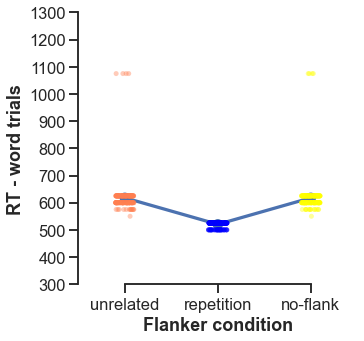

In [20]:
# Initialize the figure
f, ax = plt.subplots(figsize=(5,5))

# Show each observation with a scatterplot
sns.stripplot(x="condition", y="RT",
              data=behav2plot, dodge=False, jitter=True,order=["unrelated", "repetition","no-flank"],
              palette=["coral", "blue", "yellow"],
              alpha=.4)

# Show the conditional means
sns.pointplot(x="condition", y="RT", 
              data=behav2plot, dodge=.05, join=True,errwidth=1.5,ci=95,
                scale=0.8,order=["unrelated", "repetition","no-flank"],bw=.2)

ax.set_xlabel("Flanker condition",fontdict=dict(weight='bold'))
ax.set_ylabel("RT - word trials",fontdict=dict(weight='bold'))
ax.set_yticks([300, 400, 500,600, 700, 800, 900, 1000, 1100, 1200, 1300])

sns.set(style="ticks")
sns.set_context('talk')
sns.color_palette("Paired")
sns.despine(offset=0, trim=True)


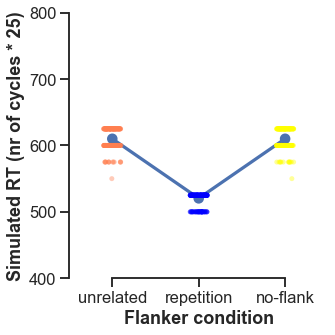

In [21]:
# Initialize the figure
f, ax = plt.subplots(figsize=(5,5))
cor2plot = behav2plot.copy(deep=True)
cor2plot = cor2plot[cor2plot['correct']==1]

# Show each observation with a scatterplot
sns.stripplot(x="condition", y="RT",
              data=cor2plot, dodge=False, jitter=True,order=["unrelated", "repetition","no-flank"],
              palette=["coral", "blue", "yellow"],
              alpha=.4)

# Show the conditional means
sns.pointplot(x="condition", y="RT", 
              data=cor2plot, dodge=.05, join=True,errwidth=1.5,ci=95,
                scale=0.8,order=["unrelated", "repetition","no-flank"],bw=.2)

ax.set_xlabel("Flanker condition",fontdict=dict(weight='bold'))
ax.set_ylabel("Simulated RT (nr of cycles * 25)",fontdict=dict(weight='bold'))
ax.set_yticks([400, 500,600, 700, 800])

sns.set(style="ticks")
sns.set_context('talk')
sns.color_palette("Paired")
sns.despine(offset=0, trim=True)

plt.tight_layout()
#plt.show()

plt.savefig("Flanker_rt_plot.pdf", format='pdf')


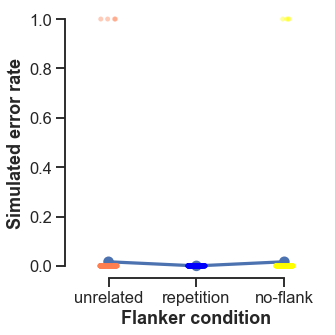

In [22]:
error = {1:0, 0:1}
behav2plot['error'] = behav2plot["correct"].replace(error, inplace=False)

# Initialize the figure
f, ax = plt.subplots(figsize=(5,5))

#Show each observation with a scatterplot
sns.stripplot(x="condition", y="error",
              data=behav2plot, dodge=False, jitter=True,order=["unrelated", "repetition","no-flank"],
              palette=["coral", "blue", "yellow"],
              alpha=.4)

# Show the conditional means
sns.pointplot(x="condition", y="error", 
              data=behav2plot, dodge=.05, join=True,errwidth=1.5,ci=95,
                scale=0.8,order=["unrelated", "repetition","no-flank"],bw=.2)
ax.set_xlabel("Flanker condition",fontdict=dict(weight='bold'))
ax.set_ylabel("Simulated error rate",fontdict=dict(weight='bold'))
ax.set_yticks([0, 0.2,0.4,0.6,0.8,1.0])

sns.set(style="ticks")
sns.set_context('talk')
sns.color_palette("Paired")
sns.despine(offset=0, trim=True)

plt.tight_layout()
#plt.show()

plt.savefig("Flanker_performance_plot.pdf", format='pdf')

### Plot target and lexicon activations in the model 

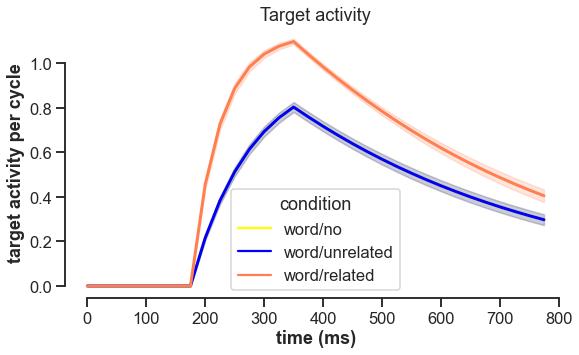

In [23]:
target2plot = df.copy(deep=True)
#data2plot = data2plot[data2plot['condition'].str.startswith(('word'))]

target2plot = target2plot.explode('target activity per cycle')
target2plot = target2plot.reset_index().rename(columns={'index': 'trial'})

# initializing list of lists 
test_list = list(range(32))
# declaring magnitude of repetition 
K = 720
  
# using list comprehension 
# repeat elements K times 
m =  K*test_list
target2plot["cycle nr"] = m
target2plot['time']= target2plot['cycle nr']*25


target2plot["target activity per cycle"] = pd.to_numeric(target2plot["target activity per cycle"].str[0], downcast="float")
f, ax = plt.subplots(figsize=(9,5))

sns.lineplot(data=target2plot, x="time", y="target activity per cycle", hue = "condition",color ='black' , ci='sd',  linewidth=3, palette=["yellow", "blue", "coral"], legend=True)

ax.set_title("Target activity")
ax.set_xlabel("time (ms)",fontdict=dict(weight='bold'))
ax.set_ylabel("target activity per cycle",fontdict=dict(weight='bold'))

sns.set(style="ticks")
sns.set_context('talk')
sns.color_palette("Paired")
sns.despine(offset=0, trim=True)



### Lexicon activations 

   trial stimulus target condition  \
0      0     lent   lent   word/no   
1      0     lent   lent   word/no   

                                               cycle  \
0  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
1  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   

  lexicon activity per cycle  \
0                          0   
1                          0   

                           target activity per cycle  \
0  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....   
1  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....   

                           bigram activity per cycle  \
0  [0.13337968354209412, 0.13337968354209412, 0.1...   
1  [0.13337968354209412, 0.13337968354209412, 0.1...   

                                              ngrams  eye position  \
0  [1, 1, 1, 1, 1, 1, 1, 1, 6, 6, 6, 6, 6, 6, 6, ...             2   
1  [1, 1, 1, 1, 1, 1, 1, 1, 6, 6, 6, 6, 6, 6, 6, ...             2   

   attention position  word threshold  word frequency  word predictabi

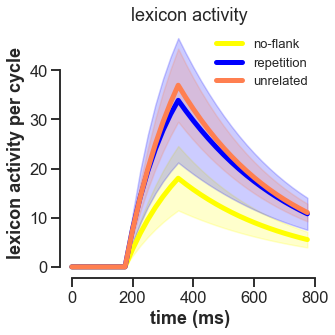

In [24]:
lexicon2plot = df.copy(deep=True)

lexicon2plot = lexicon2plot.explode('lexicon activity per cycle')
lexicon2plot = lexicon2plot.reset_index().rename(columns={'index': 'trial'})
print(lexicon2plot.head(2))

# initializing list of lists 
test_list = list(range(32))
# declaring magnitude of repetition 
K = 720
  
# using list comprehension 
# repeat elements K times 
m =  K*test_list
lexicon2plot["cycle nr"] = m
lexicon2plot['time']= (lexicon2plot['cycle nr'])*25


lexicon2plot["lexicon activity per cycle"] = pd.to_numeric(lexicon2plot["lexicon activity per cycle"], downcast="float")
f, ax = plt.subplots(figsize=(5,5))

sns.lineplot(data=lexicon2plot, x="time", y="lexicon activity per cycle",hue = "condition",color ='black' , ci='sd', hue_order=['word/no', 'word/related','word/unrelated'] ,linewidth=5,palette=["yellow", "blue", "coral"], legend=False)

ax.set_title("lexicon activity")
ax.set_xlabel("time (ms)",fontdict=dict(weight='bold'))
ax.set_ylabel("lexicon activity per cycle",fontdict=dict(weight='bold'))

sns.set(style="ticks")
sns.set_context('talk')
sns.color_palette("Paired")
sns.despine(offset=0, trim=True)

plt.tight_layout()
#plt.show()

plt.legend(loc='upper right', labels=['no-flank', 'repetition','unrelated'],frameon=False,labelspacing=0.5, scatterpoints=1, fontsize=13)


#plt.savefig("Flanker_lexicon_plot.pdf", format='pdf')



In [25]:
lexicon2plot.head(20)
lexicon_peak = lexicon2plot[(lexicon2plot['time']>=390) & (lexicon2plot['time']<= 400)].copy(deep=True)
#lexicon2plot['lexicon activity per cycle']

,trial,stimulus,target,condition,cycle,lexicon activity per cycle,target activity per cycle,bigram activity per cycle,ngrams,eye position,attention position,word threshold,word frequency,word predictability,reaction time,correct,position,cycle nr,time,bin
16,0,lent,lent,word/no,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",16.046356,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[0.13337968354209412, 0.13337968354209412, 0.1...","[1, 1, 1, 1, 1, 1, 1, 1, 6, 6, 6, 6, 6, 6, 6, ...",2,2,0.765156,0.961421,0,[625],[1],[],16,400,3
48,1,ment drap ment,drap,word/unrelated,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",23.238400,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[0.05584062249291546, 0.05584062249291546, 0.0...","[1, 1, 1, 1, 1, 1, 1, 1, 12, 12, 12, 12, 12, 1...",7,7,0.779450,0.567026,0,[625],[1],[],16,400,5
80,2,dire dire dire,dire,word/related,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",43.298923,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[0.05584062249291546, 0.05584062249291546, 0.0...","[1, 1, 1, 1, 1, 1, 1, 1, 6, 6, 6, 6, 6, 6, 6, ...",7,7,0.683716,3.208565,0,[500],[1],[],16,400,10


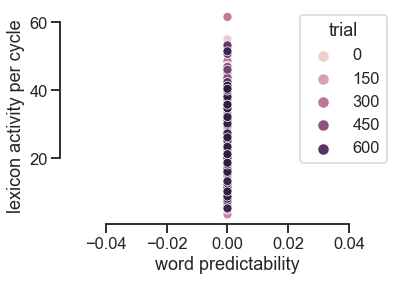

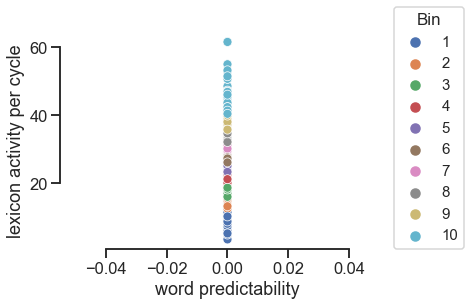

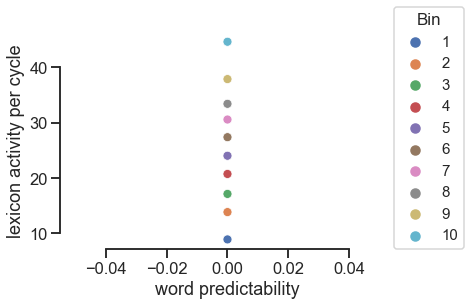

In [26]:

sns.scatterplot(data=lexicon_peak,  x="word predictability", y="lexicon activity per cycle", hue = "trial",
               )

sns.set(style="ticks")
sns.set_context('talk')
sns.color_palette("Paired")
sns.despine(offset=0, trim=True)

bin_labels_10 = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
lexicon_peak['bin'] = pd.qcut(lexicon_peak['lexicon activity per cycle'],
                              q=10,
                              labels=bin_labels_10)

plt.figure()
scat = sns.scatterplot(data=lexicon_peak,  x="word predictability", y="lexicon activity per cycle", hue = "bin",
                #color ='black',
            #kind="line", ci=95,  linewidth=3
               )

scat.legend(fontsize = 15, \
               bbox_to_anchor= (1.23, 1.15), \
               title="Bin", \
               title_fontsize = 17, \
               shadow = False, \
               facecolor = 'white');

sns.set(style="ticks")
sns.set_context('talk')
sns.color_palette("Paired")
sns.despine(offset=0, trim=True)

plt.figure()
scat = sns.scatterplot(data=lexicon_peak.groupby(['bin']).mean(),  x="word predictability", y="lexicon activity per cycle", hue = "bin",
                #color ='black',
            #kind="line", ci=95,  linewidth=3
               )

scat.legend(fontsize = 15, \
               bbox_to_anchor= (1.23, 1.15), \
               title="Bin", \
               title_fontsize = 17, \
               shadow = False, \
               facecolor = 'white');

sns.set(style="ticks")
sns.set_context('talk')
sns.color_palette("Paired")
sns.despine(offset=0, trim=True)

lexicon_peak.to_pickle('C:/Users/noors/Downloads/Flankerlexicon.pkl')
lexicon_peak.head(3)

In [28]:

#lexicon_peak.to_pickle('C:/Users/noors/Downloads/Sentencelexicon.pkl')
flanker_lexicon_peak = lexicon_peak[['trial','stimulus', 'target', 'word predictability', 'lexicon activity per cycle','bin', 'condition', 'reaction time', 'correct']].copy(deep=True)
flanker_lexicon_peak.to_pickle('C:/Users/noors/Downloads/flanker_lexicon_peak.pkl')
flanker_lexicon_peak.head(3)

flanker_lexicon_peak.head(3)


,trial,stimulus,target,word predictability,lexicon activity per cycle,bin,condition,reaction time,correct
16,0,lent,lent,0,16.046356,3,word/no,[625],[1]
48,1,ment drap ment,drap,0,23.238400,5,word/unrelated,[625],[1]
80,2,dire dire dire,dire,0,43.298923,10,word/related,[500],[1]


### Load EEG data

In [29]:
data_path = "E:/Projects/2020_reading/Data/Flankers/EEG_preprocessed/"
EEG_files = glob.glob(data_path+'*.fif') # returns 40 EEG files
print('there are %i EEG files' %len(EEG_files))

from scipy.io import loadmat
excluded = [5, 7,11 ] #list of participants to exclude 
all_subj = []
df = pd.DataFrame()

# selection of electrodes 
elecs=['Fz','Cz','POz']
    
for electrode in elecs: 
    for p in tqdm(range(0,len(EEG_files))):
        
        if p in excluded:  
            continue

        epochs = mne.read_epochs('E:/Projects/2020_reading/Data/Flankers/EEG_preprocessed/pp_' + str(p) + '_1211_picks_baseline-epo.fif', verbose=None)
        data = np.squeeze(epochs.get_data(picks=electrode))     
        cond_nr = epochs.metadata['eventcodes']
        stimulus = epochs.metadata['target']
        corr = epochs.metadata['correct']

        cond = pd.DataFrame(cond_nr)
        cond.reset_index(drop=True, inplace=True)
                
        stim = pd.DataFrame(stimulus)
        stim.reset_index(drop=True, inplace=True)
        
        cor = pd.DataFrame(corr)
        cor.reset_index(drop=True, inplace=True)
    
        df = pd.DataFrame(data)
        df.reset_index(drop=True,inplace=True)
        df['channel_id'] = electrode
        df['subj_idx'] = p
        df['condition'] = cond['eventcodes']
        df['stimulus'] = stim['target']
        df['correct'] = cor['correct']
        df = df[df['correct']== 1]
        
        df = df.melt(id_vars=['subj_idx','channel_id','condition','stimulus', 'correct'], var_name='timepoint')
    
        all_subj.append(df)
        
data = pd.concat(all_subj)        
data.head(10)


  0%|          | 0/21 [00:00<?, ?it/s]

there are 21 EEG files
Reading E:/Projects/2020_reading/Data/Flankers/EEG_preprocessed/pp_0_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
468 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated


  5%|▍         | 1/21 [00:00<00:02,  7.22it/s]

Reading E:/Projects/2020_reading/Data/Flankers/EEG_preprocessed/pp_1_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated


 10%|▉         | 2/21 [00:00<00:02,  7.79it/s]

Reading E:/Projects/2020_reading/Data/Flankers/EEG_preprocessed/pp_2_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
479 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated


 14%|█▍        | 3/21 [00:00<00:02,  8.01it/s]

Reading E:/Projects/2020_reading/Data/Flankers/EEG_preprocessed/pp_3_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
428 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
Reading E:/Projects/2020_reading/Data/Flankers/EEG_preprocessed/pp_4_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated


 24%|██▍       | 5/21 [00:00<00:01,  8.58it/s]

Reading E:/Projects/2020_reading/Data/Flankers/EEG_preprocessed/pp_6_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
472 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
Reading E:/Projects/2020_reading/Data/Flankers/EEG_preprocessed/pp_8_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated


 43%|████▎     | 9/21 [00:00<00:01, 10.29it/s]

Reading E:/Projects/2020_reading/Data/Flankers/EEG_preprocessed/pp_9_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
Reading E:/Projects/2020_reading/Data/Flankers/EEG_preprocessed/pp_10_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated


 52%|█████▏    | 11/21 [00:01<00:01,  9.29it/s]

Reading E:/Projects/2020_reading/Data/Flankers/EEG_preprocessed/pp_12_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated


 62%|██████▏   | 13/21 [00:01<00:00, 10.53it/s]

Reading E:/Projects/2020_reading/Data/Flankers/EEG_preprocessed/pp_13_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
Reading E:/Projects/2020_reading/Data/Flankers/EEG_preprocessed/pp_14_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated


 71%|███████▏  | 15/21 [00:01<00:00,  9.67it/s]

Reading E:/Projects/2020_reading/Data/Flankers/EEG_preprocessed/pp_15_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
Reading E:/Projects/2020_reading/Data/Flankers/EEG_preprocessed/pp_16_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated


 81%|████████  | 17/21 [00:01<00:00,  9.32it/s]

Reading E:/Projects/2020_reading/Data/Flankers/EEG_preprocessed/pp_17_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
Reading E:/Projects/2020_reading/Data/Flankers/EEG_preprocessed/pp_18_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated


 90%|█████████ | 19/21 [00:01<00:00,  9.54it/s]

Reading E:/Projects/2020_reading/Data/Flankers/EEG_preprocessed/pp_19_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated


 95%|█████████▌| 20/21 [00:01<00:00,  9.17it/s]

Reading E:/Projects/2020_reading/Data/Flankers/EEG_preprocessed/pp_20_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated


  0%|          | 0/21 [00:00<?, ?it/s]

Reading E:/Projects/2020_reading/Data/Flankers/EEG_preprocessed/pp_0_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
468 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
Reading E:/Projects/2020_reading/Data/Flankers/EEG_preprocessed/pp_1_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated


 10%|▉         | 2/21 [00:00<00:01, 12.68it/s]

Reading E:/Projects/2020_reading/Data/Flankers/EEG_preprocessed/pp_2_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
479 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated


 14%|█▍        | 3/21 [00:00<00:01, 11.65it/s]

Reading E:/Projects/2020_reading/Data/Flankers/EEG_preprocessed/pp_3_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
428 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
Reading E:/Projects/2020_reading/Data/Flankers/EEG_preprocessed/pp_4_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated


 24%|██▍       | 5/21 [00:00<00:01, 11.43it/s]

Reading E:/Projects/2020_reading/Data/Flankers/EEG_preprocessed/pp_6_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
472 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated


 33%|███▎      | 7/21 [00:00<00:01, 12.26it/s]

Reading E:/Projects/2020_reading/Data/Flankers/EEG_preprocessed/pp_8_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated


 43%|████▎     | 9/21 [00:00<00:00, 13.47it/s]

Reading E:/Projects/2020_reading/Data/Flankers/EEG_preprocessed/pp_9_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
Reading E:/Projects/2020_reading/Data/Flankers/EEG_preprocessed/pp_10_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated


 52%|█████▏    | 11/21 [00:00<00:00, 12.52it/s]

Reading E:/Projects/2020_reading/Data/Flankers/EEG_preprocessed/pp_12_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
Reading E:/Projects/2020_reading/Data/Flankers/EEG_preprocessed/pp_13_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated


 67%|██████▋   | 14/21 [00:01<00:00, 13.87it/s]

Reading E:/Projects/2020_reading/Data/Flankers/EEG_preprocessed/pp_14_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
Reading E:/Projects/2020_reading/Data/Flankers/EEG_preprocessed/pp_15_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated


 76%|███████▌  | 16/21 [00:01<00:00, 14.22it/s]

Reading E:/Projects/2020_reading/Data/Flankers/EEG_preprocessed/pp_16_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
Reading E:/Projects/2020_reading/Data/Flankers/EEG_preprocessed/pp_17_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated


 86%|████████▌ | 18/21 [00:01<00:00, 14.53it/s]

Reading E:/Projects/2020_reading/Data/Flankers/EEG_preprocessed/pp_18_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
Reading E:/Projects/2020_reading/Data/Flankers/EEG_preprocessed/pp_19_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated


 95%|█████████▌| 20/21 [00:01<00:00, 14.28it/s]

Reading E:/Projects/2020_reading/Data/Flankers/EEG_preprocessed/pp_20_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated


  0%|          | 0/21 [00:00<?, ?it/s]

Reading E:/Projects/2020_reading/Data/Flankers/EEG_preprocessed/pp_0_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
468 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
Reading E:/Projects/2020_reading/Data/Flankers/EEG_preprocessed/pp_1_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated


 10%|▉         | 2/21 [00:00<00:01, 18.85it/s]

Reading E:/Projects/2020_reading/Data/Flankers/EEG_preprocessed/pp_2_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
479 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
Reading E:/Projects/2020_reading/Data/Flankers/EEG_preprocessed/pp_3_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
428 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated


 19%|█▉        | 4/21 [00:00<00:00, 18.75it/s]

Reading E:/Projects/2020_reading/Data/Flankers/EEG_preprocessed/pp_4_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
Reading E:/Projects/2020_reading/Data/Flankers/EEG_preprocessed/pp_6_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
472 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated


 33%|███▎      | 7/21 [00:00<00:00, 19.63it/s]

Reading E:/Projects/2020_reading/Data/Flankers/EEG_preprocessed/pp_8_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
Reading E:/Projects/2020_reading/Data/Flankers/EEG_preprocessed/pp_9_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated


 48%|████▊     | 10/21 [00:00<00:00, 20.28it/s]

Reading E:/Projects/2020_reading/Data/Flankers/EEG_preprocessed/pp_10_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
Reading E:/Projects/2020_reading/Data/Flankers/EEG_preprocessed/pp_12_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated


 62%|██████▏   | 13/21 [00:00<00:00, 20.25it/s]

Reading E:/Projects/2020_reading/Data/Flankers/EEG_preprocessed/pp_13_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
Reading E:/Projects/2020_reading/Data/Flankers/EEG_preprocessed/pp_14_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated


 71%|███████▏  | 15/21 [00:00<00:00, 14.99it/s]

Reading E:/Projects/2020_reading/Data/Flankers/EEG_preprocessed/pp_15_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
Reading E:/Projects/2020_reading/Data/Flankers/EEG_preprocessed/pp_16_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated


 81%|████████  | 17/21 [00:01<00:00, 14.04it/s]

Reading E:/Projects/2020_reading/Data/Flankers/EEG_preprocessed/pp_17_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
Reading E:/Projects/2020_reading/Data/Flankers/EEG_preprocessed/pp_18_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated


 90%|█████████ | 19/21 [00:01<00:00, 14.33it/s]

Reading E:/Projects/2020_reading/Data/Flankers/EEG_preprocessed/pp_19_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated
Reading E:/Projects/2020_reading/Data/Flankers/EEG_preprocessed/pp_20_1211_picks_baseline-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    1496.09 ms
        0 CTF compensation matrices available
480 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 6 columns
0 projection items activated


100%|██████████| 21/21 [00:01<00:00, 16.42it/s]


,subj_idx,channel_id,condition,stimulus,correct,timepoint,value
0,0,Fz,65311,lent,1,0,-1.231276e-05
1,0,Fz,65301,ment drap ment,1,0,-3.148658e-07
2,0,Fz,65302,sabe cofi sabe,1,0,-3.417395e-06
3,0,Fz,65292,uise uise uise,1,0,3.300677e-08
4,0,Fz,65291,dire dire dire,1,0,-3.652495e-06
5,0,Fz,65302,flin uter flin,1,0,-6.088457e-06
6,0,Fz,65291,deux deux deux,1,0,-1.388122e-05
7,0,Fz,65311,oeuf,1,0,5.620591e-07
8,0,Fz,65291,amer amer amer,1,0,6.982711e-06
9,0,Fz,65302,momb rers momb,1,0,-2.120360e-05


In [30]:
#event_dict = {'no/word': 65311, 'repetition/word': 65291, 'unrelated/word': 65301, 
word_conditions = [65311,65291,65301]

data2plot = data[data['condition'].isin(word_conditions)].copy(deep=True)
data2plot['inverse_value']=data2plot['value']*-1e6
data2plot['value'] = data2plot['value']*1e6
data2plot['time']=data2plot['timepoint'].astype(int)*(1.25/320)-0.4
data2plot['stimulus'] = data2plot['stimulus'].str.strip()

#data2plot = data2plot[data2plot[timepoint]>64]

data2plot.head(100)

,subj_idx,channel_id,condition,stimulus,correct,timepoint,value,inverse_value,time
0,0,Fz,65311,lent,1,0,-12.312758,12.312758,-0.4
1,0,Fz,65301,ment drap ment,1,0,-0.314866,0.314866,-0.4
4,0,Fz,65291,dire dire dire,1,0,-3.652495,3.652495,-0.4
6,0,Fz,65291,deux deux deux,1,0,-13.881223,13.881223,-0.4
7,0,Fz,65311,oeuf,1,0,0.562059,-0.562059,-0.4
...,...,...,...,...,...,...,...,...,...
207,0,Fz,65311,main,1,0,6.119733,-6.119733,-0.4
210,0,Fz,65311,noir,1,0,-2.392353,2.392353,-0.4
211,0,Fz,65291,aube aube aube,1,0,3.149590,-3.149590,-0.4
214,0,Fz,65291,apte apte apte,1,0,-1.074902,1.074902,-0.4


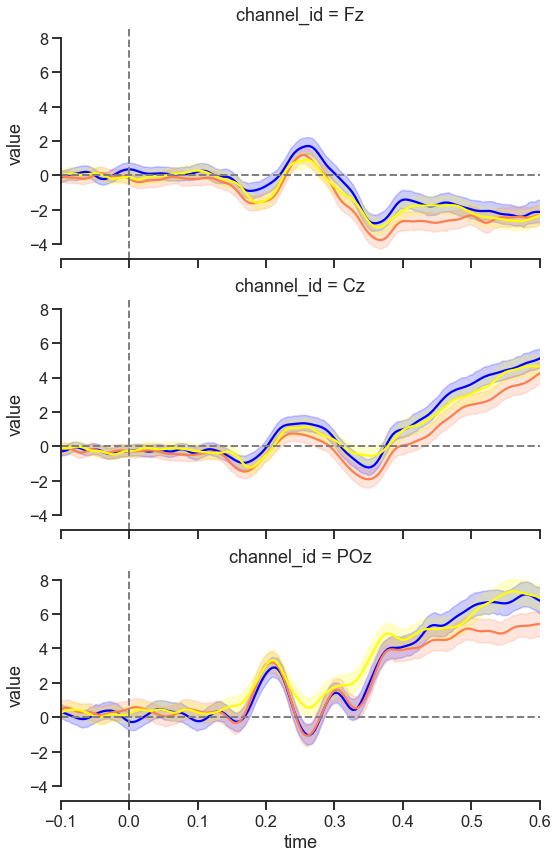

In [31]:
# Plot the responses for different events and regions. Blue=1 wrd, red=repet, yellow=difwrd
erp_plot = sns.relplot(x="time", y="value",ci=95,
             hue="condition",row="channel_id",kind="line",# style="event",
            palette = ['blue', 'coral','yellow'],legend=False,
             data=data2plot)

erp_plot.set(xlim=(-0.1, 0.6))
erp_plot.set(xticks=[-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
erp_plot.fig.set_figwidth(8.27)
erp_plot.fig.set_figheight(11.7)


for ax in erp_plot.axes.flat:
    ax.axvline(0, ls='--', linewidth=2, color="gray")
    ax.axhline(0, ls='--', linewidth=2, color="gray")

sns.set(style="ticks")
sns.set_context('talk')
sns.color_palette("Paired")
sns.despine(offset=0, trim=True)

### Okay, so now we have a dataframe with the EEG values:

In [34]:
data2plot.head(-3)

,subj_idx,channel_id,condition,stimulus,correct,timepoint,value,inverse_value,time
0,0,Fz,65311,lent,1,0,-12.312758,12.312758,-0.400000
1,0,Fz,65301,ment drap ment,1,0,-0.314866,0.314866,-0.400000
4,0,Fz,65291,dire dire dire,1,0,-3.652495,3.652495,-0.400000
6,0,Fz,65291,deux deux deux,1,0,-13.881223,13.881223,-0.400000
7,0,Fz,65311,oeuf,1,0,0.562059,-0.562059,-0.400000
...,...,...,...,...,...,...,...,...,...
149092,20,POz,65311,cuve,1,319,16.624172,-16.624172,0.846094
149093,20,POz,65311,ciel,1,319,-17.705205,17.705205,0.846094
149095,20,POz,65311,boit,1,319,-24.429970,24.429970,0.846094
149096,20,POz,65291,film film film,1,319,-15.415880,15.415880,0.846094


### And a dataframe with the OB1 values:

In [33]:
#flanker_lexicon_peak['item_condition'] =flanker_lexicon_peak['item'].astype(str) + flanker_lexicon_peak['condition']
flanker_lexicon_peak.head(-3)


,trial,stimulus,target,word predictability,lexicon activity per cycle,bin,condition,reaction time,correct
16,0,lent,lent,0,16.046356,3,word/no,[625],[1]
48,1,ment drap ment,drap,0,23.238400,5,word/unrelated,[625],[1]
80,2,dire dire dire,dire,0,43.298923,10,word/related,[500],[1]
112,3,deux deux deux,deux,0,25.526796,6,word/related,[500],[1]
144,4,oeuf,oeuf,0,16.939058,3,word/no,[625],[1]
...,...,...,...,...,...,...,...,...,...
22800,712,drap drap drap,drap,0,10.196818,1,word/related,[525],[1]
22832,713,faux faux faux,faux,0,18.651508,3,word/related,[525],[1]
22864,714,aube pipi aube,pipi,0,26.123489,6,word/unrelated,[575],[1]
22896,715,cage poil cage,poil,0,34.673553,8,word/unrelated,[600],[1]


### Find a way to merge them! We do this by taking the stimulus:

In [36]:
bindict = dict(zip(flanker_lexicon_peak['stimulus'], flanker_lexicon_peak['bin']))
actdict = dict(zip(flanker_lexicon_peak['stimulus'], flanker_lexicon_peak['lexicon activity per cycle']))

data2plot['bin'] = data2plot['stimulus'].map(bindict)
data2plot['OB1 activity'] = data2plot['stimulus'].map(actdict)
data2plot.head(3)


,subj_idx,channel_id,condition,stimulus,correct,timepoint,value,inverse_value,time,bin,OB1 activity
0,0,Fz,65311,lent,1,0,-12.312758,12.312758,-0.4,3,16.046356
1,0,Fz,65301,ment drap ment,1,0,-0.314866,0.314866,-0.4,5,23.238400
4,0,Fz,65291,dire dire dire,1,0,-3.652495,3.652495,-0.4,10,43.298923


In [45]:
lexiconN400 = data2plot[(data2plot['time']>.249) & (data2plot['time']< .450)].copy(deep=True)


SpearmanrResult(correlation=-0.07878787878787878, pvalue=0.8287173946974606)
SpearmanrResult(correlation=-0.29696969696969694, pvalue=0.4047016712701569)
SpearmanrResult(correlation=-0.6121212121212121, pvalue=0.059972142477255234)


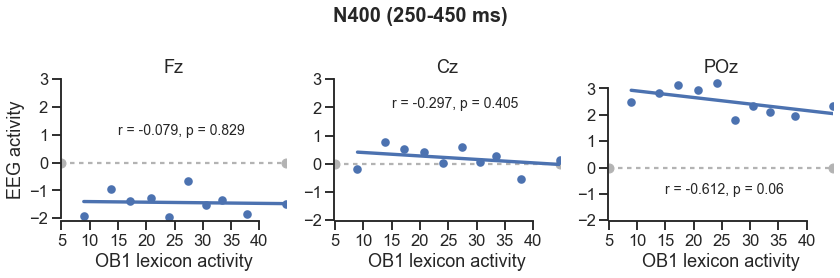

In [46]:
# Show the results of a linear regression within each dataset
sns.set(style="ticks")
sns.set_context('talk')
sns.color_palette("Paired")

g = sns.lmplot(x="OB1 activity", y="value", col="channel_id", data=lexiconN400.groupby(['bin', 'channel_id'],as_index=False).mean(),
           col_order= ['Fz', 'Cz', 'POz'],#col_wrap=2, 
               palette="muted", height=4 ,x_estimator=np.mean,fit_reg=True,ci=None,
           scatter_kws={"s": 50, "alpha": 1},sharey=False)

g.set(xticks=[5,10,15,20,25,30,35,40], yticks=[-2,-1,0,1,2,3])

g.fig.suptitle("N400 (250-450 ms)", size=20, weight="bold")


(g.map(plt.axhline, y=0, color=".7", dashes=(2, 2), zorder=0)
  .set_axis_labels("OB1 lexicon activity", "EEG activity")
  .set_titles("{col_name}")
  .tight_layout(w_pad=1))


fz = lexiconN400[lexiconN400["channel_id"]=="Fz"].groupby(['bin'],as_index=False).mean().copy(deep=True)
[fz_r, fz_p] = scipy.stats.spearmanr(fz['OB1 activity'], fz['value'])
print(scipy.stats.spearmanr(fz['OB1 activity'], fz['value']))


cz = lexiconN400[lexiconN400["channel_id"]=="Cz"].groupby(['bin'],as_index=False).mean().copy(deep=True)
[cz_r, cz_p] = scipy.stats.spearmanr(cz['OB1 activity'], cz['value'])

print(scipy.stats.spearmanr(cz['OB1 activity'], cz['value']))

poz = lexiconN400[lexiconN400["channel_id"]=="POz"].groupby(['bin'],as_index=False).mean().copy(deep=True)
[poz_r, poz_p] = scipy.stats.spearmanr(poz['OB1 activity'], poz['value'])

print(scipy.stats.spearmanr(poz['OB1 activity'], poz['value']))

for i, ax in enumerate(g.fig.axes):
    if i==0:
        ax.text(15, 1, "r = " +round(fz_r,3).astype(str) + ", p = " +round(fz_p,3).astype(str), fontsize=14)
    elif i==1:
        ax.text(15,2, "r = " +round(cz_r,3).astype(str) + ", p = " +round(cz_p,3).astype(str), fontsize=14)
    else:
        ax.text(15, -1,"r = " +round(poz_r,3).astype(str) + ", p = " +round(poz_p,3).astype(str), fontsize=14)

sns.despine(offset=0.9, trim=True)